In [ ]:
!pip install torch
!pip install tab-transformer-pytorch


### Preparing the data

In [4]:
import pandas as pd

In [6]:
## Loading dataset 
df = pd.read_csv(r'C:\Users\wwwsu\Desktop\All folders\Assessment_FleetPanda\data\raw\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data Preprocessing

In [ ]:
## Dropping customerID column
df = df.drop(columns=['customerID'])

In [8]:
## Converting the target column to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [16]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many NaN values appeared due to conversion
print(df['TotalCharges'].isnull().sum())


11


In [17]:
# Drop rows where TotalCharges is NaN
df = df.dropna(subset=['TotalCharges'])


In [9]:
## Defining categorical and numerical columns
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                    'PaperlessBilling', 'PaymentMethod']

continuous_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']


In [10]:
## Label encoding categorical columns
from sklearn.preprocessing import LabelEncoder

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


In [19]:
## Normalizing continuous columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   int64  
 7   InternetService   7032 non-null   int64  
 8   OnlineSecurity    7032 non-null   int64  
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   int64  
 11  TechSupport       7032 non-null   int64  
 12  StreamingTV       7032 non-null   int64  
 13  StreamingMovies   7032 non-null   int64  
 14  Contract          7032 non-null   int64  
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null   int64  
 17  

### Splitting data into training and testing sets

In [20]:
from sklearn.model_selection import train_test_split

X_cat = df[categorical_cols].values
X_cont = df[continuous_cols].values
y = df['Churn'].values

X_cat_train, X_cat_test, X_cont_train, X_cont_test, y_train, y_test = train_test_split(
    X_cat, X_cont, y, test_size=0.2, random_state=42, stratify=y
)


### Creating Pytorch Dataset

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

class ChurnDataset(Dataset):
    def __init__(self, cat_data, cont_data, targets):
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)      # categorical features as long (integers)
        self.cont_data = torch.tensor(cont_data, dtype=torch.float)   # continuous features as float
        self.targets = torch.tensor(targets, dtype=torch.float)       # targets as float (for BCE loss)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.cat_data[idx], self.cont_data[idx], self.targets[idx]


In [22]:
## Creating dataloaders
batch_size = 64

train_dataset = ChurnDataset(X_cat_train, X_cont_train, y_train)
test_dataset = ChurnDataset(X_cat_test, X_cont_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [23]:
## Getting the number of unique categories per categorical column

categories = [df[col].nunique() for col in categorical_cols]
print(categories)


[2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4]


In [24]:
from tab_transformer_pytorch import TabTransformer
import torch.nn as nn

model = TabTransformer(
    categories=categories,
    num_continuous=len(continuous_cols),
    dim=32,              # embedding dimension
    dim_out=1,           # output dimension (1 for binary classification)
    depth=6,             # number of transformer layers
    heads=8,             # number of attention heads
    attn_dropout=0.1,    # attention dropout
    ff_dropout=0.1,      # feed-forward dropout
    mlp_hidden_mults=(4, 2),  # MLP hidden layer size multipliers
    mlp_act=nn.ReLU()
)


### Define Loss Function and Optimizer

Since this is a binary classification problem (predicting churn: 0 or 1), we use Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss), which combines a sigmoid layer and the binary cross-entropy loss in one.

In [25]:
import torch.nn as nn
import torch.optim as optim

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer (Adam is a good default choice)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Training Loop 

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for cat_data, cont_data, targets in train_loader:
        cat_data = cat_data.to(device)
        cont_data = cont_data.to(device)
        targets = targets.to(device).unsqueeze(1)  # make targets shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(cat_data, cont_data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * cat_data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 0.5011
Epoch 2/10, Loss: 0.4367
Epoch 3/10, Loss: 0.4338
Epoch 4/10, Loss: 0.4325
Epoch 5/10, Loss: 0.4287
Epoch 6/10, Loss: 0.4257
Epoch 7/10, Loss: 0.4249
Epoch 8/10, Loss: 0.4191
Epoch 9/10, Loss: 0.4214
Epoch 10/10, Loss: 0.4113


### Evaluation 

In [27]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for cat_data, cont_data, targets in test_loader:
        cat_data = cat_data.to(device)
        cont_data = cont_data.to(device)
        targets = targets.to(device).unsqueeze(1)

        outputs = model(cat_data, cont_data)
        preds = torch.sigmoid(outputs) >= 0.5
        correct += (preds.float() == targets).sum().item()
        total += targets.size(0)

print(f"Test Accuracy: {correct / total:.4f}")


Test Accuracy: 0.7804


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

model.eval()
all_targets = []
all_preds = []
all_probs = []

with torch.no_grad():
    for cat_data, cont_data, targets in test_loader:
        cat_data = cat_data.to(device)
        cont_data = cont_data.to(device)
        targets = targets.to(device)

        outputs = model(cat_data, cont_data)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()  # predicted probabilities
        preds = (probs >= 0.5).astype(int)                     # predicted classes (0 or 1)

        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)


In [29]:
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
auc = roc_auc_score(all_targets, all_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")


Precision: 0.5890
Recall:    0.5749
F1-score:  0.5819
AUC-ROC:   0.8088


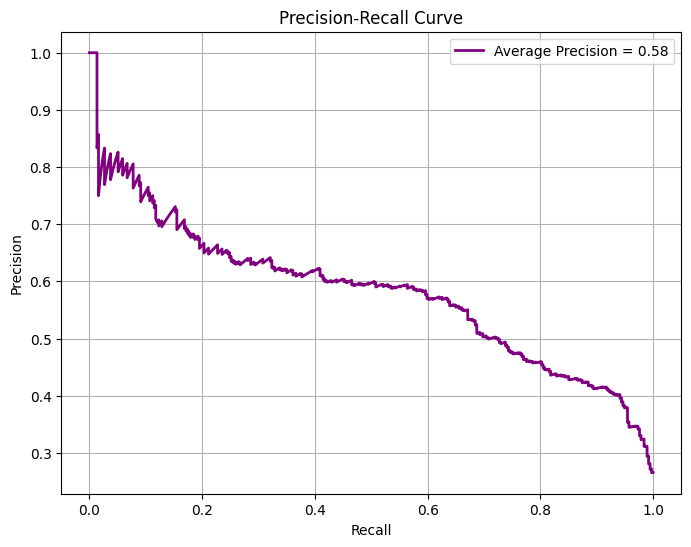

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(all_targets, all_probs)

# Compute average precision score (area under the precision-recall curve)
avg_precision = average_precision_score(all_targets, all_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='purple', lw=2, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()
